# Building a classifier for detecting tuberculosis in chest X-rays
By Jonathan Feenstra (s1024219) and Justin Huberts (s1030368)

In this project we attempt to construct a binary Extreme Learning Machine (ELM) classifier to detect tuberculosis in lung X-rays. The U.S. National Library of Medicine has made two datasets of postero-anterior chest radiographs available which we will use to train and test our model: the Montgomery County Set and the Shenzen Set (Jaeger et al., 2014).

The datasets are available for download at [https://ceb.nlm.nih.gov/repositories/tuberculosis-chest-x-ray-image-data-sets/](https://ceb.nlm.nih.gov/repositories/tuberculosis-chest-x-ray-image-data-sets/)

## Sources
- Jaeger, S., Candemir, S., Antani, S., Wáng, Y., Lu, P., & Thoma, G. (2014). Two public chest X-ray datasets for computer-aided screening of pulmonary diseases. _Quantitative Imaging In Medicine And Surgery, 4_(6), 475-477.

## Some example images:

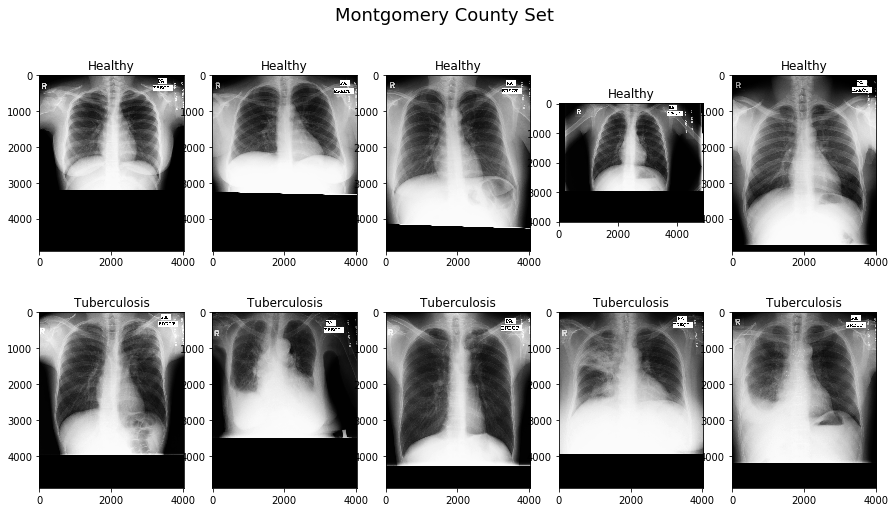

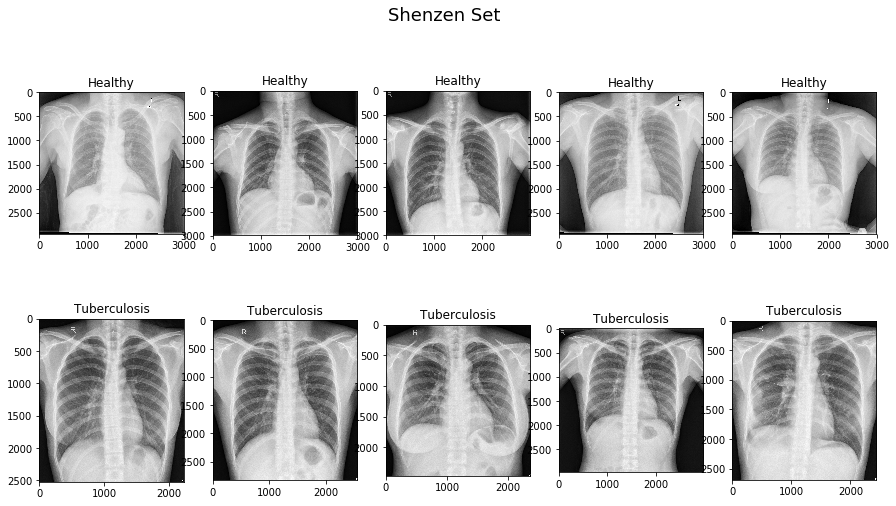

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from random import sample
import numpy as np
import glob
%matplotlib inline

mont_tb_neg = glob.glob('Data/MontgomerySet/CXR_png/*_0.png')
mont_tb_pos = glob.glob('Data/MontgomerySet/CXR_png/*_1.png')
shen_tb_neg = glob.glob('Data/ChinaSet_AllFiles/CXR_png/*_0.png')
shen_tb_pos = glob.glob('Data/ChinaSet_AllFiles/CXR_png/*_1.png')

mont_set = mont_tb_neg + mont_tb_pos
shen_set = shen_tb_neg + shen_tb_pos

mont_tb_neg_sample = sample(mont_tb_neg, 5)
mont_tb_pos_sample = sample(mont_tb_pos, 5)
shen_tb_neg_sample = sample(shen_tb_neg, 5)
shen_tb_pos_sample = sample(shen_tb_pos, 5)

mont_fig = plt.figure(figsize=(15,8))
mont_fig.suptitle('Montgomery County Set', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    img = mpimg.imread(filename)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

shen_fig = plt.figure(figsize=(15,8))
shen_fig.suptitle('Shenzen Set', size=18)
for i, filename in enumerate(shen_tb_neg_sample + shen_tb_pos_sample):
    img = mpimg.imread(filename)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')
        
plt.show()

### Observations
Since all Montgomery County images have a default size of either 4,020×4,892 or 4,892×4,020 pixels, while the actual X-ray size varies, some images contain empty space (black background). For the Shenzen Set this is not the case, but here the image sizes vary more.

## Pre-processing
### Step 1: Trim the Montgomery set images to remove empty space

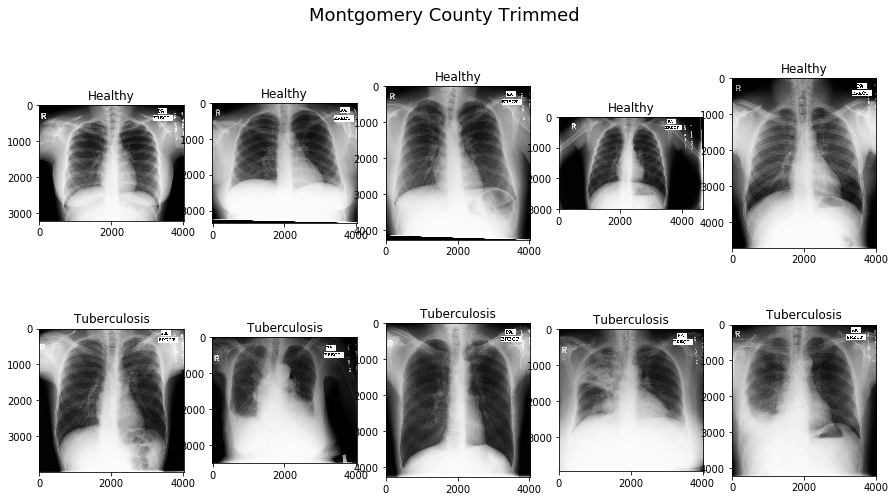

In [2]:
from PIL import Image, ImageChops
import numpy as np

# This code was used to trim the images:

# def trim(im):
#     bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
#     diff = ImageChops.difference(im, bg)
#     diff = ImageChops.add(diff, diff, 2.0, -100)
#     bbox = diff.getbbox()
#     if bbox:
#         return im.crop(bbox)

# for filename in mont_set:
#     trim(Image.open(filename)).save(filename.replace('CXR_png', 'Trimmed'))

mont_set = glob.glob('Data/MontgomerySet/Trimmed/*.png')

trim_fig = plt.figure(figsize=(15,8))
trim_fig.suptitle('Montgomery County Trimmed', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.array(Image.open(filename.replace('CXR_png', 'Trimmed'))), cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')
    
plt.show()

### Observations
Now that the empty spaces of the images are trimmed away, the Montgomery County image sizes vary as well.

### Step 2: Compress all images to 1024 x 1024 pixels

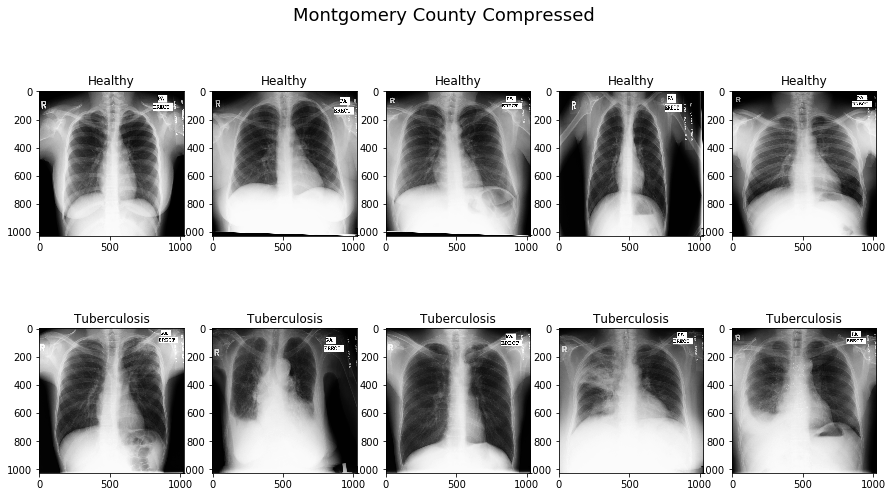

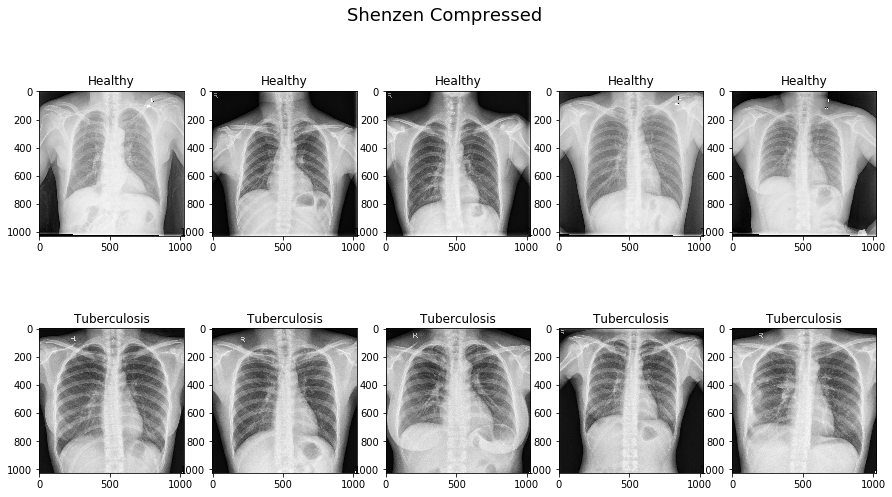

In [3]:
# This code was used to compress the images:

# for i, filename in enumerate(mont_set):
#     Image.open(filename).resize((1024,1024),Image.ANTIALIAS).save(filename.replace('Trimmed', 'Compressed'))
    
# for i, filename in enumerate(shen_set):
#     Image.open(filename).resize((1024,1024),Image.ANTIALIAS).save(filename.replace('CXR_png', 'Compressed'))

mont_fig = plt.figure(figsize=(15,8))
mont_fig.suptitle('Montgomery County Compressed', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.array(Image.open(filename.replace('CXR_png', 'Compressed'))), cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

shen_fig = plt.figure(figsize=(15,8))
shen_fig.suptitle('Shenzen Compressed', size=18)
for i, filename in enumerate(shen_tb_neg_sample + shen_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.array(Image.open(filename.replace('CXR_png', 'Compressed')).convert('L')), cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')
    
plt.show()

### Observations
As expected, all images are now 1024 x 1024 pixels, which has changed the horizontal/vertical scale a bit for all images that were not square-shaped. Hopefully this does not negatively affect the performance of the classifier.

### Step 3: Invert colors to prepare the images for bone shadow suppression

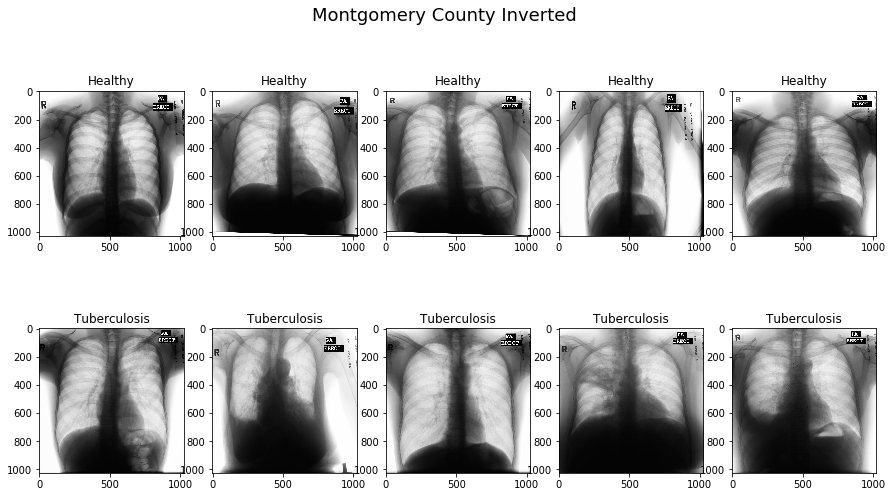

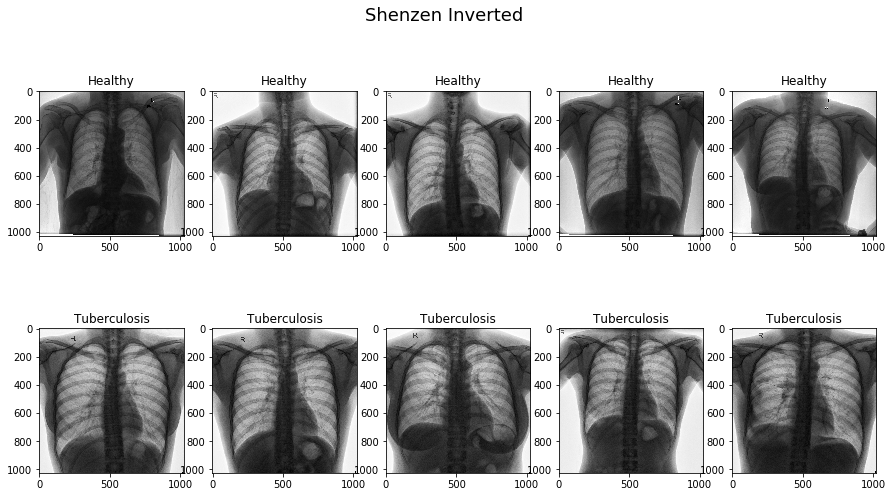

In [4]:
# This code was used to invert colors:

# import os
# import PIL.ImageOps

# for filename in glob.glob('Data/MontgomerySet/Compressed/*.png') + glob.glob('Data/ChinaSet_AllFiles/Compressed/*.png'):
#     PIL.ImageOps.invert(Image.open(filename).convert('L')).save('Data/Inverted/' + os.path.basename(filename))

mont_fig = plt.figure(figsize=(15,8))
mont_fig.suptitle('Montgomery County Inverted', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.array(Image.open(filename.replace('MontgomerySet/CXR_png', 'Inverted'))), cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')
    
shen_fig = plt.figure(figsize=(15,8))
shen_fig.suptitle('Shenzen Inverted', size=18)
for i, filename in enumerate(shen_tb_neg_sample + shen_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.array(Image.open(filename.replace('ChinaSet_AllFiles/CXR_png', 'Inverted')).convert('L')), cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')
    
plt.show()

### Observations
The colors were inverted properly, which has made the lungs brighter than the other parts of the chest. Remarkably, the lungs in the Montgomery County Set appear to look brighter than those in the Shenzen Set.

### Step 4: Apply bone shadow suppression
For this step we used the pretrained model from  [https://github.com/hmchuong/ML-BoneSuppression](https://github.com/hmchuong/ML-BoneSuppression) to suppress the bone shadows of the inverted images using the following shell script (BASH):
```
#!/bin/bash
for filename in ./Data/Inverted/*
do
    python test.py --input \$filename --output "\${filename/Inverted/Suppressed}"
done
```
Note that executing this script requires some of the files from the [GitHub repository](https://github.com/hmchuong/ML-BoneSuppression).

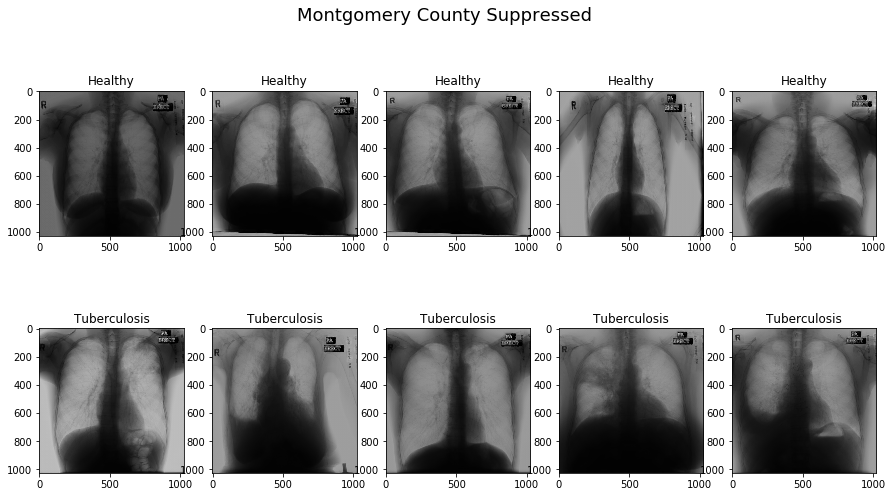

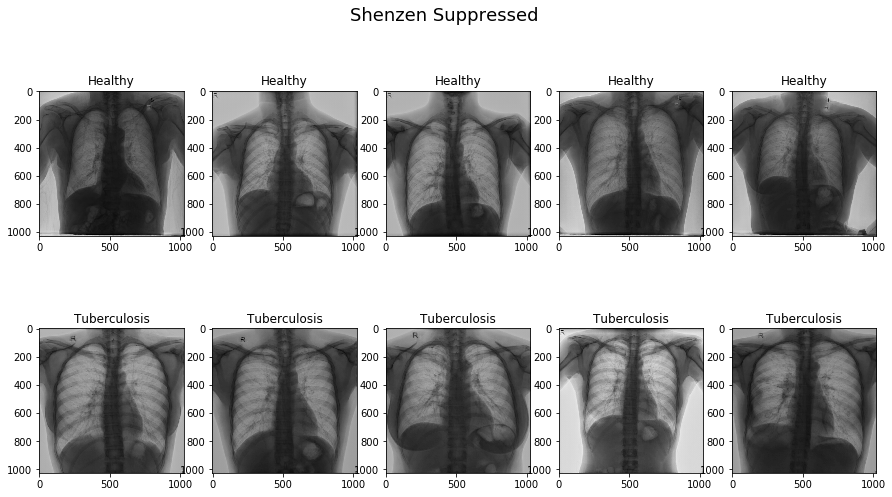

In [5]:
mont_fig = plt.figure(figsize=(15,8))
mont_fig.suptitle('Montgomery County Suppressed', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.array(Image.open(filename.replace('MontgomerySet/CXR_png', 'Suppressed'))), cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')
    
shen_fig = plt.figure(figsize=(15,8))
shen_fig.suptitle('Shenzen Suppressed', size=18)
for i, filename in enumerate(shen_tb_neg_sample + shen_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.array(Image.open(filename.replace('ChinaSet_AllFiles/CXR_png', 'Suppressed'))), cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')
    
plt.show()

### Observations
The bone shadows have significantly been suppressed, especially for the Montgomery County Set.

### Step 5: Reconstruct the images using an autoencoder

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(data)

import numpy as np
import random

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(1024, 1024))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(1024, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model

decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

#mont_set.sort(key=lambda x: x.filename, reverse=True)
#random.seed(42)
#random.shuffle(mont_set) # shuffles the ordering of the data

#
from PIL import Image
import os
import glob

mont_set = []

#mont_set.sort(key=lambda x: x.filename, reverse=True)
random.seed(42)
random.shuffle(mont_set) # shuffles the ordering of the data

for filename in glob.glob('Data/Suppressed/*.png'):
    img = np.frombuffer(Image.open(filename).tobytes(), dtype=np.uint8)
    if os.path.basename(filename)[0] == 'C': #M
        mont_set.append(img)
        

#        
        
for index, img in enumerate(mont_set):
    img = np.frombuffer(img.tobytes(), dtype=np.uint8)
    img = img.reshape((1024, 1024))  
    mont_set[index] = img

split_1 = int(0.8 * len(mont_set))
split_2 = int(0.9 * len(mont_set))
x_train = np.array(mont_set[:split_1])
#dev_filenames = mont_set[split_1:split_2]
x_test = np.array(mont_set[split_2:])

# print(x_train.shape)
# print(x_test.shape)

# x_train = x_train[:0,:]
# x_test = x_test[:0,:]

# print(x_train.shape)
# print(x_test.shape)

autoencoder.fit(x_train, x_train,
                epochs=1, #50
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:
import matplotlib.pyplot as plt
from numpy import reshape

imgd = encoded_imgs[-0]
print(imgd.shape)

I = reshape(imgd,((1024, 32)))
plt.imshow(I, extent=(32,1024,32,1024));
plt.title("img");
plt.tight_layout()
plt.show()
    
plt.show()    

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, LeakyReLU, Activation


from PIL import Image
import os
import glob
import random
import numpy as np

# mont_set = []

# #mont_set.sort(key=lambda x: x.filename, reverse=True)
# random.seed(42)
# random.shuffle(mont_set) # shuffles the ordering of the data

# for filename in glob.glob('Data/Suppressed/*.png'):
#     img = np.frombuffer(Image.open(filename).tobytes(), dtype=np.uint8)
#     if os.path.basename(filename)[0] == 'C': #M
#         mont_set.append(img)
               
        
# for index, img in enumerate(mont_set):
#     img = np.frombuffer(img.tobytes(), dtype=np.uint8)
#     img = img.reshape((1024, 1024))  
#     mont_set[index] = img

# split_1 = int(0.8 * len(mont_set))
# split_2 = int(0.9 * len(mont_set))
# x_train = np.array(mont_set[:split_1])
# x_test = np.array(mont_set[split_2:])

mont_images = []
shen_images = []
mont_labels = []
shen_labels = []

for filename in glob.glob('Data/Suppressed/*.png'):
    img = np.frombuffer(Image.open(filename).tobytes(), dtype=np.uint8)
    if os.path.basename(filename)[0] == 'C':
        img = img.reshape((1024, 1024)) 
        shen_images.append(img)
        shen_labels.append(int(os.path.splitext(filename)[0][-1]))
    elif os.path.basename(filename)[0] == 'M':
        img = img.reshape((1024, 1024)) 
        mont_images.append(img)
        mont_labels.append(int(os.path.splitext(filename)[0][-1]))        
           
# Ik test de ELM hier op alle data om te controleren of het goed werkt
X = np.array(mont_images + shen_images)
y = np.array(mont_labels + shen_labels, dtype=np.int64)

print(X.shape)
print(y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, input_shape=(1024,1024)))
#model.add(LeakyReLU(alpha=0.05))
model.add(Conv2D(32, kernel_size=3))
model.add(Flatten())
model.add(Dense(1, activation='relu'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

#train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

#predict first 4 images in the test set
print(model.predict(X_test[:4]))

### Observations

## ELM classifier
A binary ELM classifier will be trained using the pre-processed images from the two datasets. It's performance will be evaluated by plotting an ROC-curve and a confusion matrix, as well as providing some relevant metrics.

Useful article: [https://ieeexplore.ieee.org/document/7140733](https://ieeexplore.ieee.org/document/7140733)

C:\Users\Usser\Anaconda3\lib\site-packages\hpelm\nnets\slfn.py:62: RuntimeWarning: overflow encountered in exp
  self.func["sigm"] = lambda X, W, B: 1 / (1 + np.exp(np.dot(X, W) + B))
C:\Users\Usser\Anaconda3\lib\site-packages\hpelm\nnets\slfn_python.py:65: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B = np.linalg.lstsq(HH, HT)[0]


Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons


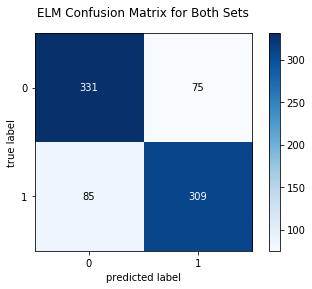

Accuracy: 0.8
Recall: 0.7842639593908629
F-measure: 0.794344473007712
MSE: 0.15116131263151164
AUC: 0.8696644244955116


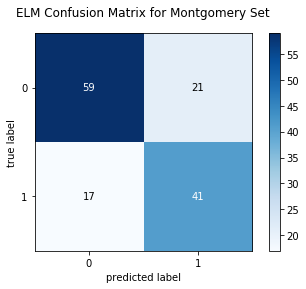

Accuracy: 0.7246376811594203
Recall: 0.7068965517241379
F-measure: 0.6833333333333333
MSE: 0.18696402776258758
AUC: 0.7872844827586207


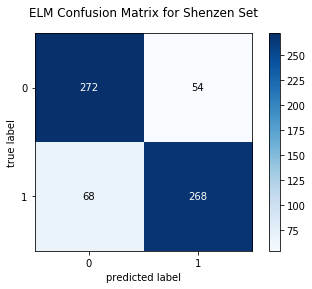

Accuracy: 0.8157099697885196
Recall: 0.7976190476190477
F-measure: 0.8145896656534954
MSE: 0.1436979067582662
AUC: 0.883481229915279


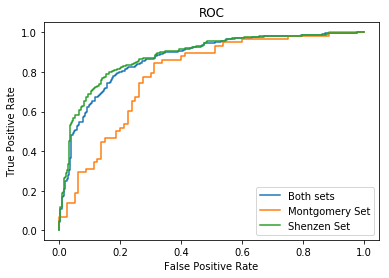

In [28]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from hpelm import ELM
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score, recall_score
from mlxtend.plotting import plot_confusion_matrix

def show_conf_matrix_and_metrics(y_true, y_pred, thresh, title):
    y_pred_classes = [0 if p < thresh else 1 for p in y_pred]
    plot_confusion_matrix(confusion_matrix(y_true, y_pred_classes), colorbar=True)
    plt.title(title)
    plt.show()
    print('Accuracy: {0}'.format(accuracy_score(y_true, y_pred_classes)))
    print('Recall: {0}'.format(recall_score(y_true, y_pred_classes)))
    print('F-measure: {0}'.format(f1_score(y_true, y_pred_classes)))
    print('MSE: {0}'.format(elm.error(y_true, y_pred)))

THRESH = 0.5

mont_images = []
shen_images = []
mont_labels = []
shen_labels = []

for filename in glob.glob('Data/Suppressed/*.png'):
    img = np.frombuffer(Image.open(filename).resize((256,256),Image.ANTIALIAS).tobytes(), dtype=np.uint8)
    if os.path.basename(filename)[0] == 'C':
        shen_images.append(img)
        shen_labels.append(int(os.path.splitext(filename)[0][-1]))
    elif os.path.basename(filename)[0] == 'M':
        mont_images.append(img)
        mont_labels.append(int(os.path.splitext(filename)[0][-1]))

X_both = np.array(mont_images + shen_images)
y_both = np.array(mont_labels + shen_labels, dtype=np.int64)

X_mont = np.array(mont_images)
y_mont = np.array(mont_labels, dtype=np.int64)

X_shen = np.array(shen_images)
y_shen = np.array(shen_labels, dtype=np.int64)

elm = ELM(65536, 1)

elm.add_neurons(100, 'sigm')
elm.add_neurons(50, 'sigm')
elm.add_neurons(2, 'sigm')

# Train en test data moet nog worden gesplitst
elm.train(X_both, y_both)

y_pred_both = elm.predict(X_both)
fpr_both, tpr_both, threshold_both = roc_curve(y_both, y_pred_both)

show_conf_matrix_and_metrics(y_both, y_pred_both, THRESH, 'ELM Confusion Matrix for Both Sets')
print('AUC: {0}'.format(auc(fpr_both, tpr_both)))

y_pred_mont = elm.predict(X_mont)
fpr_mont, tpr_mont, threshold_mont = roc_curve(y_mont, y_pred_mont)

show_conf_matrix_and_metrics(y_mont, y_pred_mont, THRESH, 'ELM Confusion Matrix for Montgomery Set')
print('AUC: {0}'.format(auc(fpr_mont, tpr_mont)))

y_pred_shen = elm.predict(X_shen)
fpr_shen, tpr_shen, threshold_shen = roc_curve(y_shen, y_pred_shen)

show_conf_matrix_and_metrics(y_shen, y_pred_shen, THRESH, 'ELM Confusion Matrix for Shenzen Set')
print('AUC: {0}'.format(auc(fpr_shen, tpr_shen)))

# ROC curve
plt.plot(fpr_both, tpr_both, label='Both sets')
plt.plot(fpr_mont, tpr_mont, label='Montgomery Set')
plt.plot(fpr_shen, tpr_shen, label='Shenzen Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC')

plt.show()

# TODO: k-fold cross validation (k=10)

### Observations
The ELM seems to perform reasonably well for this classification task, with an accuracy, recall and F-measure around 80% for when tested on both sets together or the Shenzen Set alone. When only testing the Montgomery Set, the scores are a little lower (around 70%).

## Conclusion